# Women's E-Commerce Clothing Reviews

In [1]:
import pandas as pd
import numpy as np
import scipy
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import Image

%matplotlib inline

## 데이터 로드

In [3]:
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv", index_col=0)
print(df.shape)
df.head(3)

(23486, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


In [4]:
df.groupby(['Rating', 'Recommended IND'])['Recommended IND'].count()

Rating  Recommended IND
1       0                    826
        1                     16
2       0                   1471
        1                     94
3       0                   1682
        1                   1189
4       0                    168
        1                   4909
5       0                     25
        1                  13106
Name: Recommended IND, dtype: int64

In [5]:
df.loc[(df.Rating==5) & (df['Recommended IND']==0)]['Review Text'].iloc[1]

"This top is one of my retailer faves! it is so comfortable and love the quality and design. i receive many compliments on this top. i usually wear an xs or s in retailer tops and the xs was a little tight in the arms. the dressing room attendant suggested ordering a petite small so i wouldn't lose the shape. so glad i did. it fits perfect! i even ordered when it was on sale!! the gray color is perfect! its not too thick or thin."

In [7]:
# 피처 확인
text_df = df[['Title', 'Review Text', 'Recommended IND']]
text_df.head()

,Title,Review Text,Recommended IND
0,NaN,Absolutely wonderful - silky and sexy and comf...,1
1,NaN,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws,I had such high hopes for this dress and reall...,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1
4,Flattering shirt,This shirt is very flattering to all due to th...,1


In [8]:
# 텍스트 피처 합치기
text_df['Review'] = text_df['Title'] + ' ' + text_df['Review Text']
text_df = text_df.drop(labels=['Title','Review Text'] , axis=1)
text_df.head()

,Recommended IND,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


## 결측치 처리

In [9]:
text_df.Review.isna().sum()

3811

In [10]:
text_df = text_df[~text_df.Review.isna()]
text_df = text_df.rename(columns={"Recommended IND": "Recommended"})
print("My data's shape is:", text_df.shape)
text_df.head()

My data's shape is: (19675, 2)


,Recommended,Review
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...
5,0,Not for the very petite I love tracy reese dre...
6,1,Cagrcoal shimmer fun I aded this in my basket ...


## Target value 확인

In [11]:
text_df['Recommended'].unique()

array([0, 1], dtype=int64)

In [12]:
text_df['Recommended'].value_counts(normalize=True)

1    0.818297
0    0.181703
Name: Recommended, dtype: float64

## 피처 추가

In [13]:
text_df['Review_length'] = text_df['Review'].apply(len)
print(text_df.shape)
text_df.head()

(19675, 3)


,Recommended,Review,Review_length
2,0,Some major design flaws I had such high hopes ...,524
3,1,"My favorite buy! I love, love, love this jumps...",141
4,1,Flattering shirt This shirt is very flattering...,209
5,0,Not for the very petite I love tracy reese dre...,512
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517


In [14]:
text_df['Review_length'].describe()

count    19675.000000
mean       338.450267
std        144.740126
min         23.000000
25%        217.000000
50%        336.000000
75%        496.000000
max        557.000000
Name: Review_length, dtype: float64

<AxesSubplot:xlabel='Review_length', ylabel='Density'>

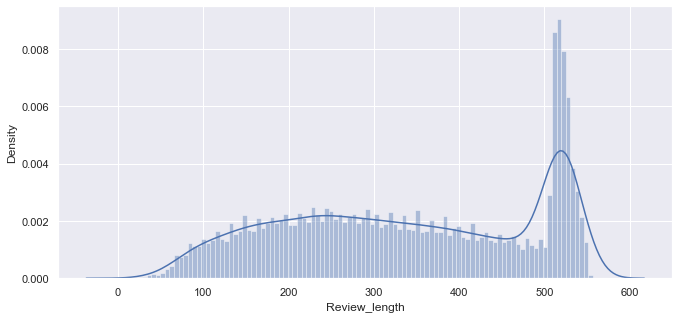

In [15]:
sns.set(rc={'figure.figsize':(11,5)})
sns.distplot(text_df['Review_length'] ,hist=True, bins=100)

In [16]:
df_zero = text_df[text_df['Recommended']==0]
df_one = text_df[text_df['Recommended']==1]

<AxesSubplot:ylabel='Density'>

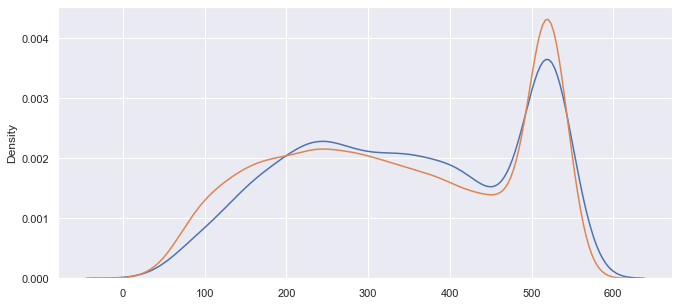

In [17]:
sns.distplot(df_zero[['Review_length']] ,hist=False)
sns.distplot(df_one[['Review_length']], hist=False)

In [18]:
def count_exclamation_mark(string_text):
    count = 0
    for char in string_text:
        if char == '!':
            count += 1
    return count

In [19]:
text_df['count_exc'] = text_df['Review'].apply(count_exclamation_mark)
text_df.head(5)

,Recommended,Review,Review_length,count_exc
2,0,Some major design flaws I had such high hopes ...,524,1
3,1,"My favorite buy! I love, love, love this jumps...",141,3
4,1,Flattering shirt This shirt is very flattering...,209,3
5,0,Not for the very petite I love tracy reese dre...,512,0
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0


In [20]:
text_df['count_exc'].describe(np.arange(0.2, 1.0, 0.2))

count    19675.000000
mean         0.883151
std          1.412098
min          0.000000
20%          0.000000
40%          0.000000
50%          0.000000
60%          1.000000
80%          2.000000
max         41.000000
Name: count_exc, dtype: float64

<AxesSubplot:>

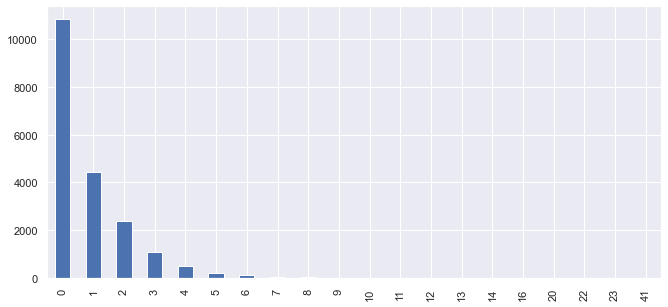

In [21]:
text_df['count_exc'].value_counts().sort_index().plot(kind='bar')

In [22]:
text_df[text_df['count_exc']== 41].index

Int64Index([3301], dtype='int64')

In [23]:
text_df['Review'][3301]

'Beautiful and unique. Love this top, just received it today.\r\nit is a very artistic interpretation for a casual top.\r\nthe blue is gorgeous!\r\nthe unique style of the peplm and the details on the front set this apart!\r\nruns a little shorter, but i feel the length enhances it;s beauty, and is appropriate for the overall design.\r\nlove !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\r\nordered my usual size and it fits perfectly.'

In [24]:
text_df['Polarity'] = text_df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
text_df.head(5)

,Recommended,Review,Review_length,count_exc,Polarity
2,0,Some major design flaws I had such high hopes ...,524,1,0.073209
3,1,"My favorite buy! I love, love, love this jumps...",141,3,0.560714
4,1,Flattering shirt This shirt is very flattering...,209,3,0.512891
5,0,Not for the very petite I love tracy reese dre...,512,0,0.181111
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0,0.157500


<AxesSubplot:ylabel='Frequency'>

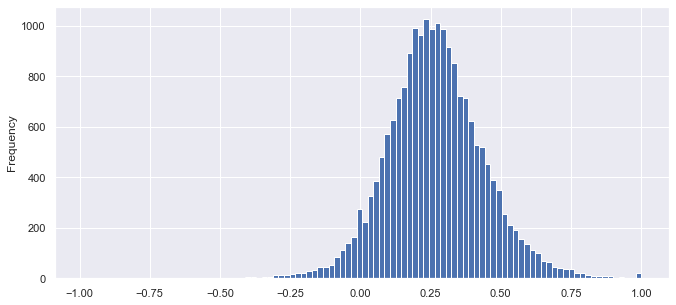

In [25]:
text_df['Polarity'].plot(kind='hist', bins=100)

In [26]:
text_prep = text_df.copy()

## 텍스트 피처 전처리

In [27]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [28]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [29]:
text_prep['Review'] = text_prep['Review'].apply(punctuation_removal)
text_prep['Review'].head()

2    Some major design flaws I had such high hopes ...
3    My favorite buy I love love love this jumpsuit...
4    Flattering shirt This shirt is very flattering...
5    Not for the very petite I love tracy reese dre...
6    Cagrcoal shimmer fun I aded this in my basket ...
Name: Review, dtype: object

In [30]:
Image(url= "http://josecarilloforum.com/imgs/longnounphrase_schematic-1B.png", width=600, height=10)

In [31]:
def adj_collector(review_string):
    new_string=[]
    review_string = word_tokenize(review_string)
    tup_word = nltk.pos_tag(review_string)
    for tup in tup_word:
        if 'VB' in tup[1] or tup[1]=='JJ':  #Verbs and Adjectives
            new_string.append(tup[0])  
    return ' '.join(new_string)

In [32]:
text_prep['Review'] = text_prep['Review'].apply(adj_collector)
text_prep['Review'].head(7)

2    major had such high wanted work i ordered smal...
3         favorite love love fabulous wear i get great
4    Flattering is flattering due adjustable is per...
5    petite love reese is petite am tall wear was i...
6    aded last see look i went am pale is gorgeous ...
7    goes ordered had try used top pair went is nic...
8    Flattering love get runs little ordered flatte...
Name: Review, dtype: object

In [33]:
# stopwords
print(stopwords.words('english')[::12])

['i', "you'd", 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', "don't", 'aren', 'haven', "shan't"]


In [34]:
stop = stopwords.words('english')
stop.append("i'm")

In [35]:
stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 
print(stop_words[::12])

['i', 'youd', 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', 'dont', 'aren', 'haven', 'shant']


In [36]:
clothes_list =['dress', 'top','sweater','shirt',
               'skirt','material', 'white', 'black',
              'jeans', 'fabric', 'color','order', 'wear']

In [37]:
def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words and word.lower() not in clothes_list ]

In [38]:
text_prep['Review'] = text_prep['Review'].apply(stopwords_removal)
text_prep['Review'].head()

2    [major, high, wanted, work, ordered, small, us...
3         [favorite, love, love, fabulous, get, great]
4    [flattering, flattering, due, adjustable, perf...
5    [petite, love, reese, petite, tall, long, full...
6    [aded, last, see, look, went, pale, gorgeous, ...
Name: Review, dtype: object

In [39]:
print(text_prep['Review'][3301])

['unique', 'received', 'artistic', 'casual', 'gorgeous', 'unique', 'runs', 'little', 'feel', 'enhances', 'appropriate', 'overall', 'ordered', 'usual', 'fits']


In [40]:
print(text_prep['Review'][267]) 

['nice', 'short', 'tall', 'iamp39d', 'say', 'fits', 'true', 'short', 'iamp39m', 'tall', 'wish', 'came']


## 숫자 제거

In [41]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

In [42]:
text_prep['Review'] = text_prep['Review'].apply(drop_numbers)
text_prep['Review'].head()

2    major high wanted work ordered small usual fou...
3                favorite love love fabulous get great
4    flattering flattering due adjustable perfect p...
5    petite love reese petite tall long full overwh...
6    aded last see look went pale gorgeous turns ma...
Name: Review, dtype: object

In [43]:
print(text_prep['Review'][267]) 

nice short tall say fits true short tall wish came


In [44]:
print(text_prep['Review'][2293])

flattering purchased return expected fit said lbs got get disappointed soft purchase regular fit looked terrible say tall thin yes short petite


## Stemming

In [45]:
porter = PorterStemmer()

In [46]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: x.split())
text_prep['Review'].head()

2    [major, high, wanted, work, ordered, small, us...
3         [favorite, love, love, fabulous, get, great]
4    [flattering, flattering, due, adjustable, perf...
5    [petite, love, reese, petite, tall, long, full...
6    [aded, last, see, look, went, pale, gorgeous, ...
Name: Review, dtype: object

In [47]:
def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = porter.stem(word)
        text_list_new.append(word) 
    return text_list_new

In [48]:
text_prep['Review'] = text_prep['Review'].apply(stem_update)
text_prep['Review'].head()

2    [major, high, want, work, order, small, usual,...
3             [favorit, love, love, fabul, get, great]
4    [flatter, flatter, due, adjust, perfect, pair,...
5    [petit, love, rees, petit, tall, long, full, o...
6    [ade, last, see, look, went, pale, gorgeou, tu...
Name: Review, dtype: object

In [49]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: ' '.join(x))
text_prep['Review'].head()

2    major high want work order small usual found s...
3                    favorit love love fabul get great
4     flatter flatter due adjust perfect pair cardigan
5    petit love rees petit tall long full overwhelm...
6    ade last see look went pale gorgeou turn mathc...
Name: Review, dtype: object

In [50]:
print(text_prep['Review'][2293])

flatter purchas return expect fit said lb got get disappoint soft purchas regular fit look terribl say tall thin ye short petit


In [51]:
pos_df = text_prep[text_prep.Recommended== 1]
neg_df = text_prep[text_prep.Recommended== 0]
pos_df.head(3)

,Recommended,Review,Review_length,count_exc,Polarity
3,1,favorit love love fabul get great,141,3,0.560714
4,1,flatter flatter due adjust perfect pair cardigan,209,3,0.512891
6,1,ade last see look went pale gorgeou turn mathc...,517,0,0.157500


In [52]:
pos_words =[]
neg_words = []

for review in pos_df.Review:
    pos_words.append(review) 
pos_words = ' '.join(pos_words)
pos_words[:40]

for review in neg_df.Review:
    neg_words.append(review)
neg_words = ' '.join(neg_words)
neg_words[:400]

'major high want work order small usual found small small zip reorder petit ok overal comfort fit bottom tight sever cheap imo major net c petit love rees petit tall long full overwhelm small shorten narrow take love work return look cheap run small run order fit tight cheap pull caus rip disappoint go say go look style side purchas knew larg next imposs second look cheap awkward tight look describ'

## 긍정적인 리뷰

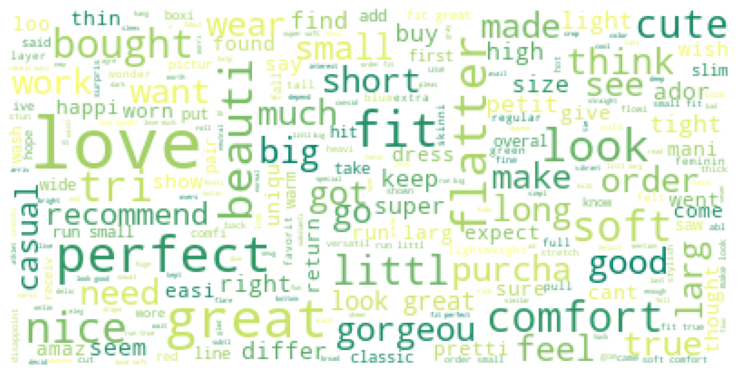

In [53]:
wordcloud = WordCloud().generate(pos_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer').generate(pos_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 부정적인 리뷰

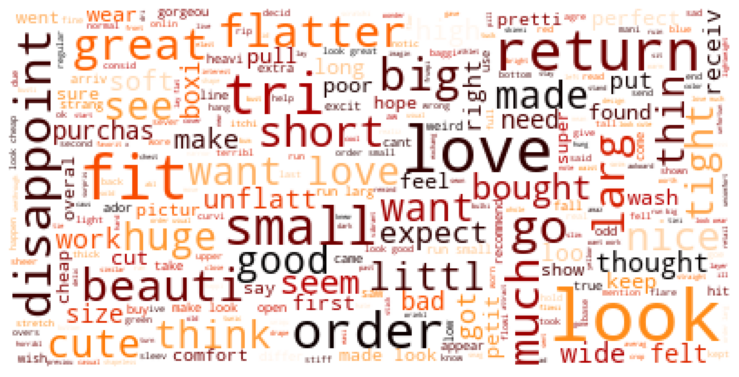

In [54]:
wordcloud = WordCloud().generate(neg_words)

wordcloud = WordCloud(background_color="white",max_words=len(neg_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat').generate(neg_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 피처 벡터화 - BoW

In [55]:
text_prep['Review'].head()

2    major high want work order small usual found s...
3                    favorit love love fabul get great
4     flatter flatter due adjust perfect pair cardigan
5    petit love rees petit tall long full overwhelm...
6    ade last see look went pale gorgeou turn mathc...
Name: Review, dtype: object

In [56]:
def text_vectorizing_process(sentence_string):
    return [word for word in sentence_string.split()]

In [60]:
bow_transformer = CountVectorizer()

In [61]:
bow_transformer.fit(text_prep['Review'])

CountVectorizer()

In [62]:
print(text_prep['Review'].iloc[3])

petit love rees petit tall long full overwhelm small shorten narrow take love work return


In [63]:
example = bow_transformer.transform([text_prep['Review'].iloc[3]])
print(example)
#3507=Love
#4438=petit

  (0, 2416)	1
  (0, 3438)	1
  (0, 3507)	2
  (0, 3881)	1
  (0, 4302)	1
  (0, 4438)	2
  (0, 4875)	1
  (0, 5004)	1
  (0, 5383)	1
  (0, 5601)	1
  (0, 6196)	1
  (0, 6201)	1
  (0, 7159)	1


In [64]:
Reviews = bow_transformer.transform(text_prep['Review'])
Reviews

<19675x7277 sparse matrix of type '<class 'numpy.int64'>'
	with 237960 stored elements in Compressed Sparse Row format>

In [65]:
print('Shape of Sparse Matrix', Reviews.shape)
print('Amount of Non-Zero occurences:', Reviews.nnz)

Shape of Sparse Matrix (19675, 7277)
Amount of Non-Zero occurences: 237960


## TF-IDF

In [67]:
tfidf_transformer = TfidfTransformer().fit(Reviews)

tfidf_example = tfidf_transformer.transform(example)
print (tfidf_example)
#3507=Love
#4438=petit

  (0, 7159)	0.18474832182622425
  (0, 6201)	0.2570248132639302
  (0, 6196)	0.2365171129379326
  (0, 5601)	0.1442941606293562
  (0, 5383)	0.355252429679757
  (0, 5004)	0.1888712992199643
  (0, 4875)	0.393148931086517
  (0, 4438)	0.4065409531496632
  (0, 4302)	0.3214748504588952
  (0, 3881)	0.3072123012448639
  (0, 3507)	0.21175884431125436
  (0, 3438)	0.20250236542769373
  (0, 2416)	0.2403172376641177


In [68]:
[i for i in bow_transformer.vocabulary_.items() if i[1]==3507]

[('love', 3507)]

In [69]:
[i for i in bow_transformer.vocabulary_.items()][6:60:10]

[('usual', 6813),
 ('tight', 6383),
 ('flatter', 2243),
 ('overwhelm', 4302),
 ('pale', 4323),
 ('said', 5133)]

In [70]:
messages_tfidf = tfidf_transformer.transform(Reviews)
messages_tfidf.shape

(19675, 7277)

In [71]:
print(messages_tfidf[:1]) 
#tuple(index_num, word_num), tfidf_proba

  (0, 7273)	0.21472646647428087
  (0, 7159)	0.12712196996857394
  (0, 6930)	0.12017260570324308
  (0, 6813)	0.1513403250714934
  (0, 6383)	0.14060642619885752
  (0, 5601)	0.29785858576976637
  (0, 5290)	0.18845614450376966
  (0, 4943)	0.2444427546112772
  (0, 4438)	0.13986672876492434
  (0, 4260)	0.15858178150697497
  (0, 4210)	0.1001757163619286
  (0, 4138)	0.20901503445074096
  (0, 3944)	0.30397328049150685
  (0, 3584)	0.5250571838807988
  (0, 2934)	0.3111586573431781
  (0, 2769)	0.14606384138147635
  (0, 2364)	0.15056928107008546
  (0, 2197)	0.08515558755200825
  (0, 1153)	0.10625437706817653
  (0, 984)	0.19198542692781725
  (0, 698)	0.18408106529286453


## 희소행렬 결합

In [72]:
messages_tfidf = messages_tfidf.toarray()
messages_tfidf = pd.DataFrame(messages_tfidf)
print(messages_tfidf.shape)
messages_tfidf.head()

(19675, 7277)


,0,1,2,3,4,5,6,7,8,9,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.214726,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [73]:
df_all = pd.merge(text_prep.drop(columns='Review'),messages_tfidf, 
                  left_index=True, right_index=True )
df_all.head()

,Recommended,Review_length,count_exc,Polarity,0,1,2,3,4,5,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
2,0,524,1,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,141,3,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,209,3,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,512,0,0.181111,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,517,0,0.157500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 데이터 분할

In [74]:
X = df_all.drop('Recommended', axis=1)
y = df_all.Recommended

X.head()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
2,524,1,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,141,3,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,209,3,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,512,0,0.181111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,517,0,0.157500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
X.shape

(16481, 7280)

In [76]:
X.describe()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
count,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.0,16481.000000,16481.000000,16481.000000,...,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000
mean,338.411261,0.876221,0.265987,0.000024,0.000030,0.000024,0.0,0.000049,0.000021,0.000020,...,0.000023,0.000025,0.000076,0.000048,0.000054,0.000021,0.002118,0.000315,0.000030,0.000125
std,144.790275,1.414203,0.172803,0.003139,0.003794,0.003098,0.0,0.004483,0.002695,0.002549,...,0.002950,0.003207,0.004952,0.004398,0.004935,0.002727,0.027395,0.010892,0.003799,0.007291
min,23.000000,0.000000,-0.987500,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,217.000000,0.000000,0.158333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,335.000000,0.000000,0.260863,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,497.000000,1.000000,0.370312,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,557.000000,41.000000,1.000000,0.402938,0.487124,0.397730,0.0,0.447529,0.345954,0.327234,...,0.378710,0.411733,0.382191,0.400114,0.496872,0.350060,0.629020,0.484828,0.487690,0.526867


In [77]:
X_train, X_test, y_train, y_test = split(X,y, test_size=0.3, stratify=y, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11536, 7280), (4945, 7280), (11536,), (4945,))

In [78]:
y_train.value_counts(normalize=True)

1    0.818741
0    0.181259
Name: Recommended, dtype: float64

In [79]:
y_test.value_counts(normalize=True)

1    0.818605
0    0.181395
Name: Recommended, dtype: float64

## 스케일링 - MinMaxScaler

In [80]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
pd.DataFrame(X_train_scaled,columns= X_train.columns).describe()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
count,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.0,11536.000000,11536.000000,11536.000000,...,11536.000000,11536.0,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.0,11536.000000
mean,0.587341,0.021667,0.631576,0.000087,0.000087,0.000087,0.0,0.000087,0.000087,0.000087,...,0.000087,0.0,0.000285,0.000087,0.000155,0.000087,0.003269,0.000680,0.0,0.000340
std,0.272417,0.035310,0.087348,0.009310,0.009310,0.009310,0.0,0.009310,0.009310,0.009310,...,0.009310,0.0,0.015486,0.009310,0.011872,0.009310,0.043065,0.023211,0.0,0.016539
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.357678,0.000000,0.577737,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.578652,0.000000,0.628931,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.885768,0.024390,0.683922,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


## PCA -> 데이터 시각화

In [82]:
pca_transformer = PCA(n_components=2).fit(X_train_scaled)
X_train_scaled_pca = pca_transformer.transform(X_train_scaled)
X_test_scaled_pca = pca_transformer.transform(X_test_scaled)
X_train_scaled_pca[:1]

array([[-0.13600042, -0.05035864]])

<AxesSubplot:>

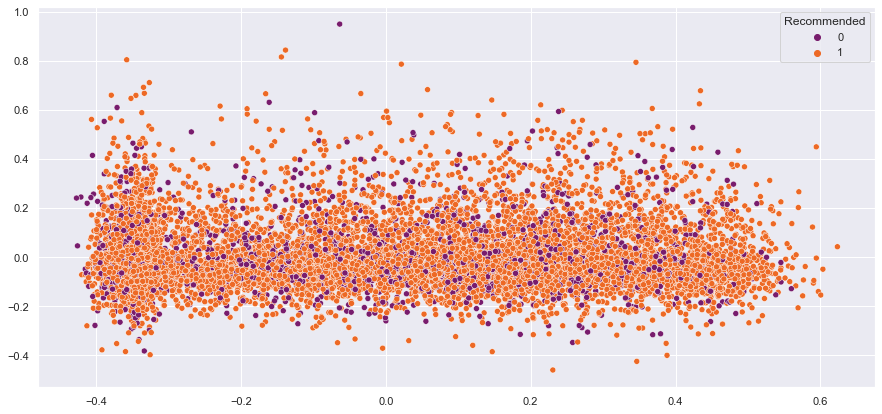

In [83]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=X_train_scaled_pca[:, 0], 
                y=X_train_scaled_pca[:, 1], 
                hue=y_train, 
                sizes=100,
                palette="inferno")

In [84]:
X_train_scaled = scipy.sparse.csr_matrix(X_train_scaled)
X_test_scaled = scipy.sparse.csr_matrix(X_test_scaled)

X_train = scipy.sparse.csr_matrix(X_train.values)
X_test = scipy.sparse.csr_matrix(X_test.values)
X_test

<4945x7280 sparse matrix of type '<class 'numpy.float64'>'
	with 71934 stored elements in Compressed Sparse Row format>

## 모델 예측/평가

In [85]:
def report(y_true, y_pred, labels):
    cm = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred), 
                                        index=labels, columns=labels)
    rep = classification_report(y_true=y_true, y_pred=y_pred)
    return (f'Confusion Matrix:\n{cm}\n\nClassification Report:\n{rep}')

### SVM

In [88]:
svc_model = SVC(C=1.0, 
             kernel='linear',
             class_weight='balanced', 
             probability=True,
             random_state=111)
svc_model.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', kernel='linear', probability=True,
    random_state=111)

In [89]:
test_predictions = svc_model.predict(X_test_scaled)
print(report(y_test, test_predictions, svc_model.classes_ ))

Confusion Matrix:
     0     1
0  517   380
1  995  3053

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.58      0.43       897
           1       0.89      0.75      0.82      4048

    accuracy                           0.72      4945
   macro avg       0.62      0.67      0.62      4945
weighted avg       0.79      0.72      0.75      4945



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

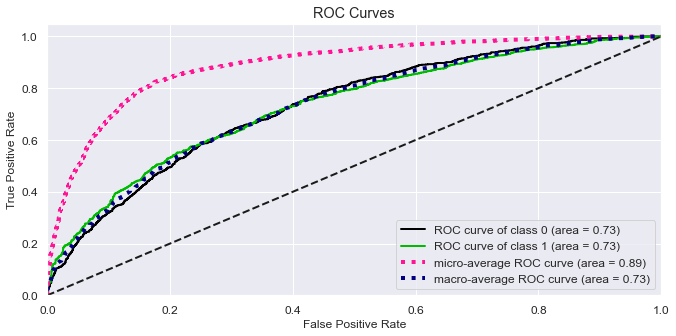

In [90]:
skplt.metrics.plot_roc(y_test, svc_model.predict_proba(X_test_scaled)) 

### 로지스틱 회귀

In [91]:
lr_model = LogisticRegression(class_weight='balanced', 
                              random_state=111, 
                              solver='lbfgs',
                              C=1.0)

gs_lr_model = GridSearchCV(lr_model, 
                           param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, 
                           cv=5, 
                           scoring='roc_auc')

gs_lr_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=111),
             param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, scoring='roc_auc')

In [92]:
gs_lr_model.best_params_

{'C': 0.1}

In [93]:
test_predictions = gs_lr_model.predict(X_test_scaled)
print(report(y_test, test_predictions, gs_lr_model.classes_ ))

Confusion Matrix:
      0     1
0   617   280
1  1100  2948

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.69      0.47       897
           1       0.91      0.73      0.81      4048

    accuracy                           0.72      4945
   macro avg       0.64      0.71      0.64      4945
weighted avg       0.81      0.72      0.75      4945



<AxesSubplot:title={'center':'ROC Curves - Logistic Regression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

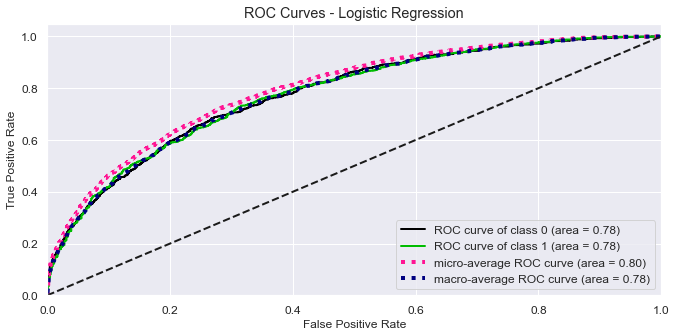

In [94]:
skplt.metrics.plot_roc(y_test, gs_lr_model.predict_proba(X_test_scaled),
                      title='ROC Curves - Logistic Regression') 

### AdaBoost

In [95]:
dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=555)

ada_model = AdaBoostClassifier(base_estimator=dt, learning_rate=0.001, n_estimators=1000, random_state=222)
ada_model.fit(X_train ,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=5,
                                                         random_state=555),
                   learning_rate=0.001, n_estimators=1000, random_state=222)

In [96]:
test_predictions = ada_model.predict(X_test)
print(report(y_test, test_predictions, ada_model.classes_ ))

Confusion Matrix:
     0     1
0  549   348
1  916  3132

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.61      0.46       897
           1       0.90      0.77      0.83      4048

    accuracy                           0.74      4945
   macro avg       0.64      0.69      0.65      4945
weighted avg       0.80      0.74      0.77      4945



<AxesSubplot:title={'center':'ROC Curves - AdaBoost'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

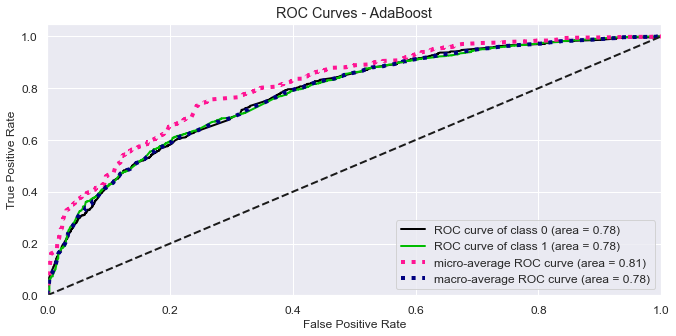

In [97]:
skplt.metrics.plot_roc(y_test, ada_model.predict_proba(X_test), 
                       title='ROC Curves - AdaBoost') 

### Random Forest

In [98]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=5, 
                                  class_weight='balanced', random_state=3)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=1000,
                       random_state=3)

In [99]:
test_predictions = rf_model.predict(X_test)
print(report(y_test, test_predictions, rf_model.classes_ ))

Confusion Matrix:
     0     1
0  535   362
1  828  3220

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.60      0.47       897
           1       0.90      0.80      0.84      4048

    accuracy                           0.76      4945
   macro avg       0.65      0.70      0.66      4945
weighted avg       0.81      0.76      0.78      4945



<AxesSubplot:title={'center':'ROC Curves - Random Forest'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

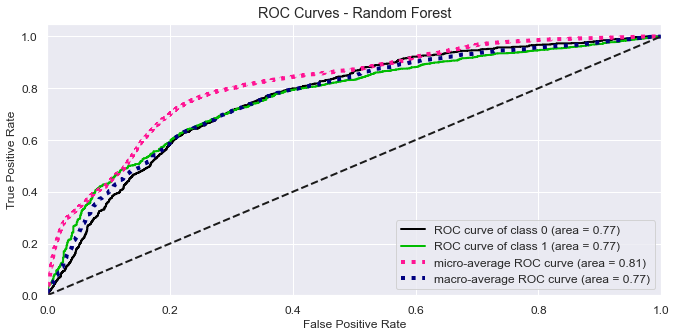

In [100]:
skplt.metrics.plot_roc(y_test, rf_model.predict_proba(X_test), 
                       title='ROC Curves - Random Forest') 

In [101]:
my_list = list(zip(rf_model.feature_importances_ ,X.columns))
my_list.sort(key=lambda tup: tup[0],reverse=True)
my_list[:7]

[(0.06291527997677081, 'Polarity'),
 (0.055157105857121864, 'count_exc'),
 (0.021406639244383446, 'Review_length'),
 (0.011894601207282649, 3465),
 (0.009851650847294266, 2416),
 (0.009284936953421651, 2546),
 (0.009115202968963206, 3522)]

In [102]:
bow_list = [i for i in bow_transformer.vocabulary_.items()]

for i in my_list:
    for j in bow_list:
        if i[1] == j[1] and i[0]> 0.005:
            print(f'Importance: {i[0]:.4f}   Word num: {i[1]}   Word:  { j[0]}')

Importance: 0.0119   Word num: 3465   Word:  look
Importance: 0.0099   Word num: 2416   Word:  full
Importance: 0.0093   Word num: 2546   Word:  good
Importance: 0.0091   Word num: 3522   Word:  low
Importance: 0.0081   Word num: 2042   Word:  extra
Importance: 0.0068   Word num: 2364   Word:  found
Importance: 0.0059   Word num: 3212   Word:  knew
Importance: 0.0055   Word num: 4832   Word:  receiv
Importance: 0.0055   Word num: 1605   Word:  differ
Importance: 0.0054   Word num: 763   Word:  bright
Importance: 0.0051   Word num: 5098   Word:  run
Importance: 0.0051   Word num: 873   Word:  buy
Importance: 0.0051   Word num: 2197   Word:  fit
Importance: 0.0050   Word num: 3438   Word:  long


In [103]:
probs = rf_model.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, probs[:,1])

Text(0, 0.5, 'TPR')

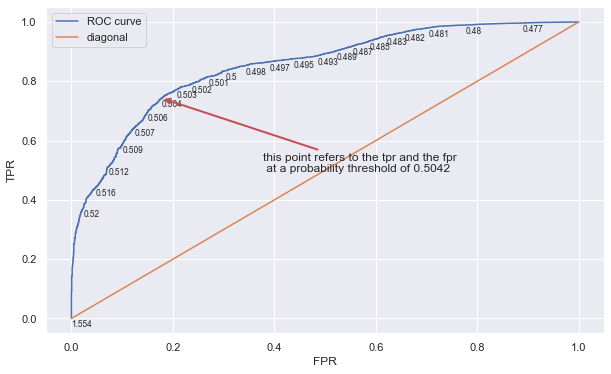

In [104]:
#Train
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::100], tpr[::100], thresholds[::100]):
    plt.annotate(np.round(txt,3), (x, y-0.03), fontsize='x-small')
rnd_idx = 700
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'\
             .format(np.round(thresholds[rnd_idx], 4)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->',color='r'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [105]:
probs = rf_model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:,1])

Text(0, 0.5, 'TPR')

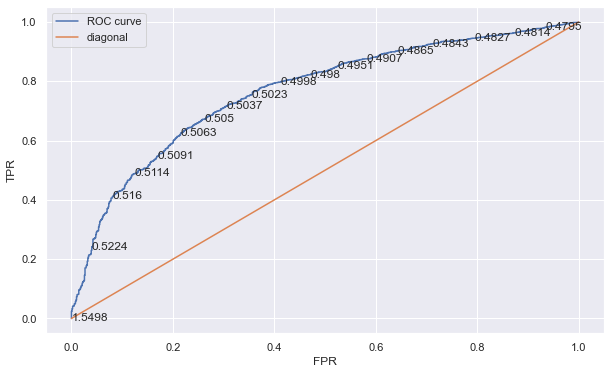

In [106]:
#Test
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::70], tpr[::70], thresholds[::70]):
    plt.annotate(np.round(txt,4), (x, y-0.01))

plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

# Topic modeling guide

## EDA

In [6]:
import numpy as np 
import pandas as pd

import sys
sys.path.append('../input/gsdmm-short-text-clustering')
#from gsdmm import MovieGroupProcess

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
import gensim, spacy
from gensim.models.ldamulticore import LdaMulticore
import re


from gensim.models import Phrases
from gensim.models.phrases import Phraser

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [7]:
data = pd.read_csv('tripadvisor_hotel_reviews.csv', encoding='utf-8')
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [8]:
data['length'] = data.Review.apply(lambda row: len(row.split()))
print('Mean length: ', data['length'].mean())

Mean length:  104.37582353228247


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='length', ylabel='Density'>

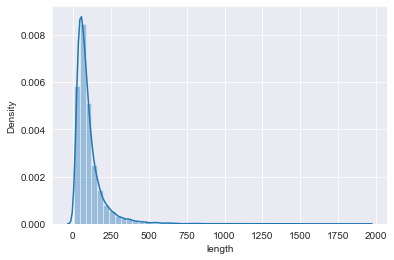

In [9]:
import seaborn as sns
sns.set_style(style="darkgrid")

sns.distplot(data['length'])

## 전처리

In [10]:
import re

data['review_list'] = data.Review.values.tolist()

# remove characters
data['review_list'] = [re.sub('\s+', ' ', sent) for sent in data['review_list']]
data['review_list'] = [re.sub("\'", "", sent) for sent in data['review_list']]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [11]:
#ngram 생성 함수
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

In [12]:
tokens_reviews = list(sent_to_words(data['review_list']))

In [13]:
tokens_reviews = make_n_grams(tokens_reviews)

In [14]:
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable


In [15]:
import spacy

In [16]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# 스톱워드 제거
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(['also', 'meanwhile','however', 'time', 
                                                                                                                           'hour', 'soon', 'day', 'book',
                                                                                                                           'there', 'hotel', 'room', 'leave',
                                                                                                                           'arrive',
                                                                                                                           'place', 'stay', 'staff', 'location',
                                                                                                                          'service', 'come', 'check',
                                                                                                                          'ask', 'lot', 'thing', 
                                                                                                                          'soooo', 'add', 'rarely',
                                                                                                                          'use', 'look', 'minute',
                                                                                                                          'bring', 'need', 'world',
                                                                                                                          'think', 'value', 'include']))] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
reviews_lemmatized = lemmatization(tokens_reviews, allowed_postags=['NOUN', 'VERB', 'ADV'])
reviews_lemmatized = remove_stopwords(reviews_lemmatized)